# EDA Part 2: Exploring flat_type as a key interaction term

In our initial model, we see that flat type and model accounted for a large part of a resale price prediction.

However, we'd like to bring down the bias which implies that we need to add in more features or consider interaction terms.

We know that HDB types can be a proxy for income levels and for people at different income levels, they have different priorities. For example, a person in a 1 room flat may prioritize an MRT station nearby because they do not own a car, 1 room flats near to MRTs will have a greater impact on demand (and thus price) for a particular unit.

We will proceed to do EDA with flat_type as a key interaction term.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv(r'..\datasets\cleaned_data.csv', index_col='Unnamed: 0')
df.head()

C:\Users\hammi\AppData\Local\Temp\ipykernel_10884\203476346.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'..\datasets\cleaned_data.csv', index_col='Unnamed: 0')


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude,block_type
0,88471,2016-05-01,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006-01-01,...,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504,mixed
1,122598,2012-07-01,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987-01-01,...,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892,mixed
2,170897,2013-07-01,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997-01-01,...,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013,mixed
3,86070,2012-04-01,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992-01-01,...,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934,mixed
4,153632,2017-12-01,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987-01-01,...,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335,mixed


In [3]:
df.columns[43]

'Latitude'

In [4]:
df['postal'] = df['postal'].astype(str)

Convert to datetime

In [5]:
df['Tranc_YearMonth'] = pd.to_datetime(df['Tranc_YearMonth'])
df['Tranc_Year'] = pd.to_datetime(df['Tranc_Year'])
df['Tranc_Month'] = pd.to_datetime(df['Tranc_Month'])
df['lease_commence_date'] = pd.to_datetime(df['lease_commence_date'])
df['year_completed'] = pd.to_datetime(df['year_completed'])

In [6]:
df['resale_price'].head()

0    6.80
1    6.65
2    8.38
3    5.50
4    2.98
Name: resale_price, dtype: float64

In [7]:
def find_sig_corr(df,list_of_features):
    for feature in list_of_features:
        corr = df.corrwith(df[feature])['resale_price']
        if abs(corr)>0.5:
            print(f"{feature}:{corr}")
    return

Add ordinal data for time to do regression

In [8]:
date_data = ['Tranc_YearMonth','Tranc_Year','Tranc_Month','lease_commence_date','year_completed']
for datetime_column in date_data:
    df[f"{datetime_column}_ord"] = df[datetime_column].map(lambda d: d.toordinal())

In [9]:
list_of_numeric_features = df.select_dtypes(include='number').columns.to_list()

For the list of categorical features, we will include `flat_model` and `planning_area`.

Since `planning_area` is strongly related `mrt_name` and school names, we would want to not include the latter features to avoid collinearity.

We also left out storey range as it is covered under the median floor in numeric features.

In [10]:
list_of_categorical_features = ['flat_model', 'planning_area', 'block_type']

Function to plot boxplots for categorical features.

Green -> Upper Quantile
Orange -> Median
Red -> Lower Quantile

In [11]:
def boxes(df, list_of_features:list, flat_type:str):
    for feature in list_of_features:
        temp = (df.loc[:,[feature,'resale_price']]
            .groupby([feature])
            .median()
            .sort_values(by='resale_price'))

        fig, ax = plt.subplots(figsize=(10,10))
        ax.set(title=f"{flat_type}: Resale against {feature}")
        sns.boxplot(ax=ax,y=feature, x='resale_price', data=df,order=temp.index,orient='h', color='skyblue', showfliers=False)
        ax = plt.axvline(x=df['resale_price'].median(), color = 'orange')
        ax = plt.axvline(x=df['resale_price'].quantile(.25),color='red')
        ax = plt.axvline(x=df['resale_price'].quantile(.75),color='green');
    return

# Resale Price correlations wrt flat type

In [12]:
flat_types = df['flat_type'].unique().tolist()

In [13]:
flat_types.sort()
flat_types

['1 ROOM',
 '2 ROOM',
 '3 ROOM',
 '4 ROOM',
 '5 ROOM',
 'EXECUTIVE',
 'MULTI-GENERATION']

## 1 Room flats

In [14]:
df_1room = df[df['flat_type']==flat_types[0]].copy()

In [15]:
find_sig_corr(df_1room,list_of_numeric_features)

resale_price:1.0
price_per_sqft:1.0
Tranc_YearMonth_ord:-0.8138538722232959
Tranc_Year_ord:-0.8049887872495315


There's a very strong (negative) correlation with transaction date.

Check correlation with datetime.

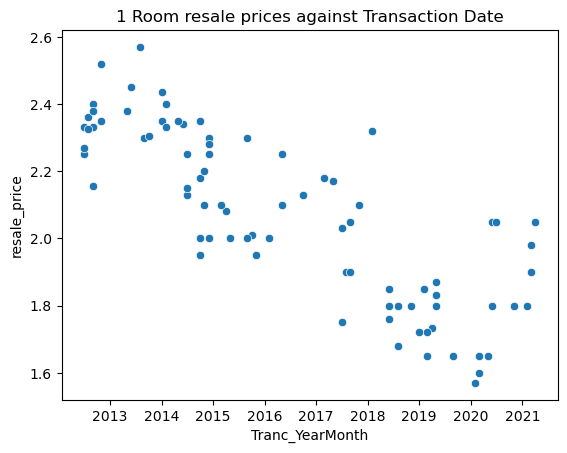

In [16]:
plt.title('1 Room resale prices against Transaction Date')
sns.scatterplot(data=df_1room, x='Tranc_YearMonth', y='resale_price');

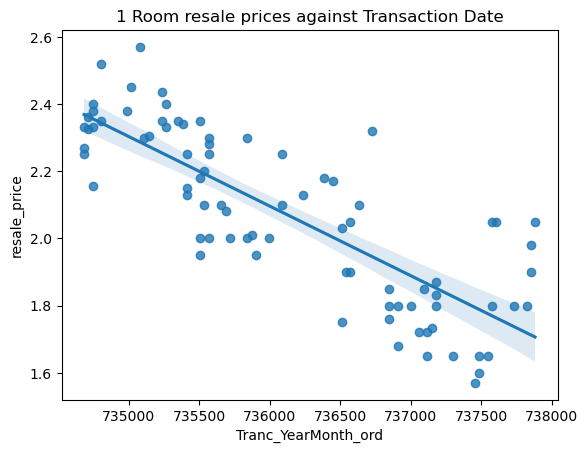

In [17]:
plt.title('1 Room resale prices against Transaction Date')
sns.regplot(data=df_1room, x='Tranc_YearMonth_ord', y='resale_price');

We will include `1 ROOM`\*`Tranc_YearMonth_ord` in our new model.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

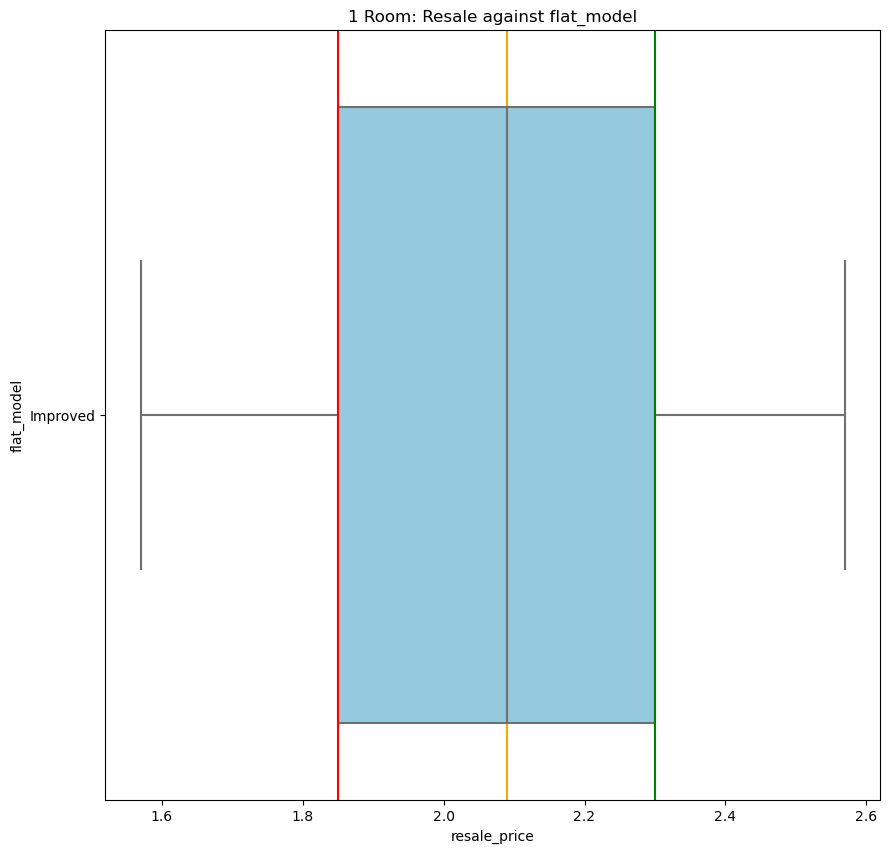

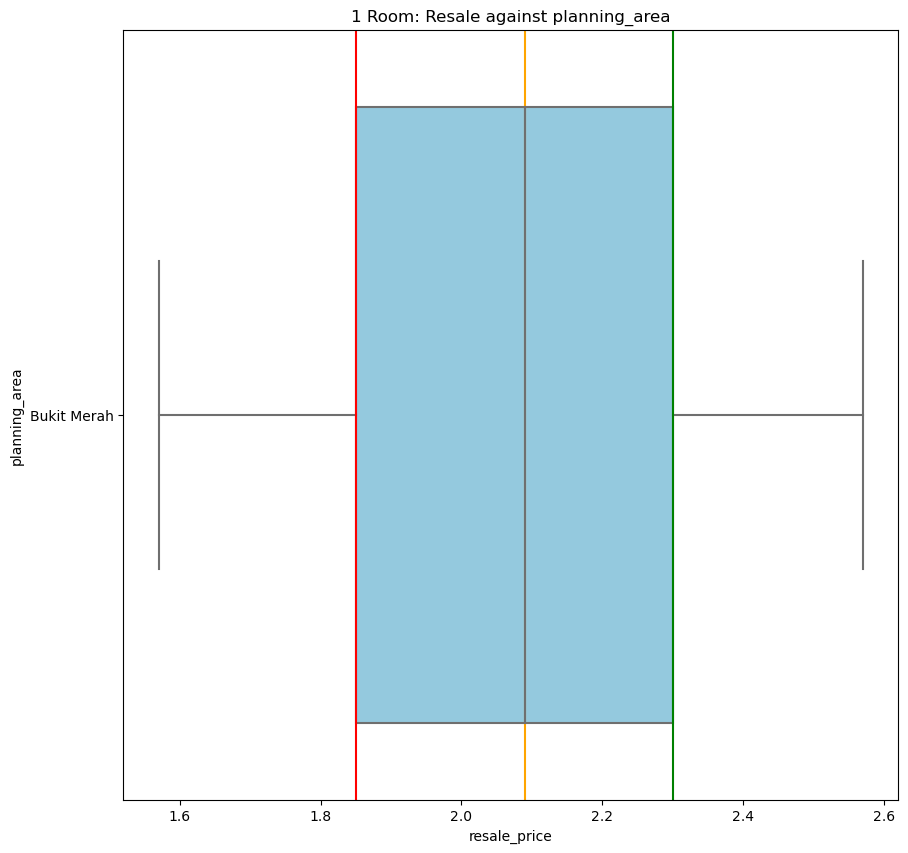

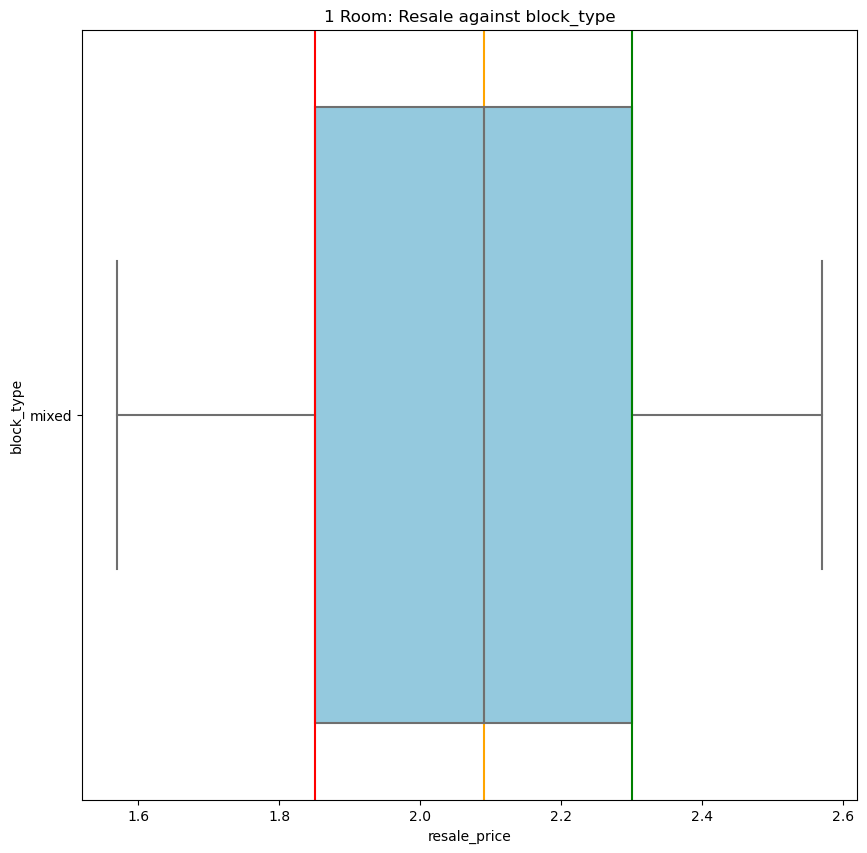

In [18]:
boxes(df_1room, list_of_categorical_features, '1 Room')

We see that for the 1 rooms transacted, there is only one planning area, one flat model and one block type.

So for one room flats, we'll use `flat_type_1 ROOM`, and `1 ROOM`\*`Tranc_YearMonth_ord` for our features.

---

# 2 room flats

In [19]:
df_2room = df[df['flat_type']==flat_types[1]].copy()

In [20]:
find_sig_corr(df_2room,list_of_numeric_features)

resale_price:0.9999999999999999
price_per_sqft:0.8520197395038968


There appears to be no strong correlation between resale prices of 2 room flats and the numerical features.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

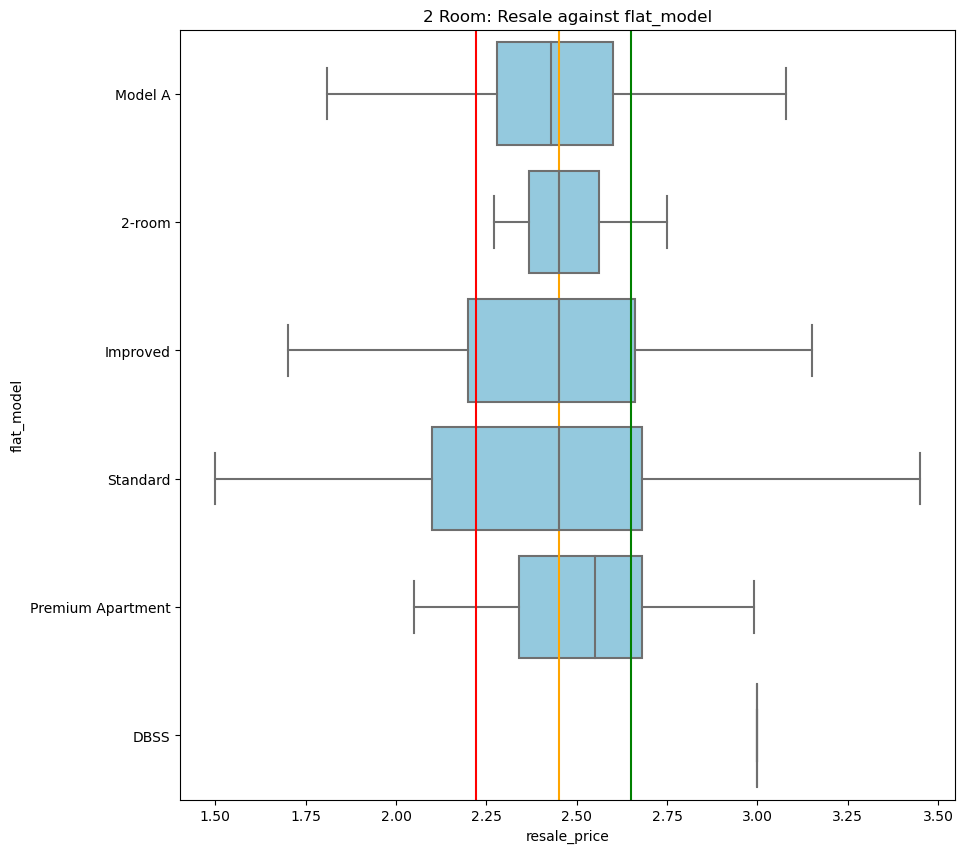

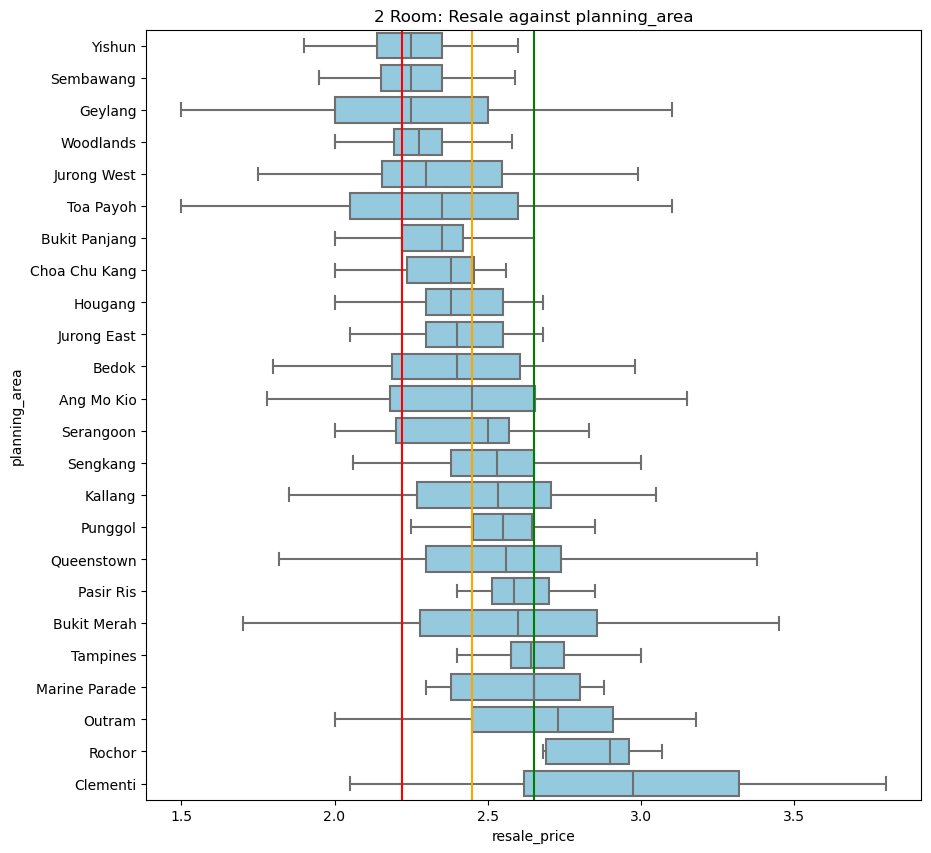

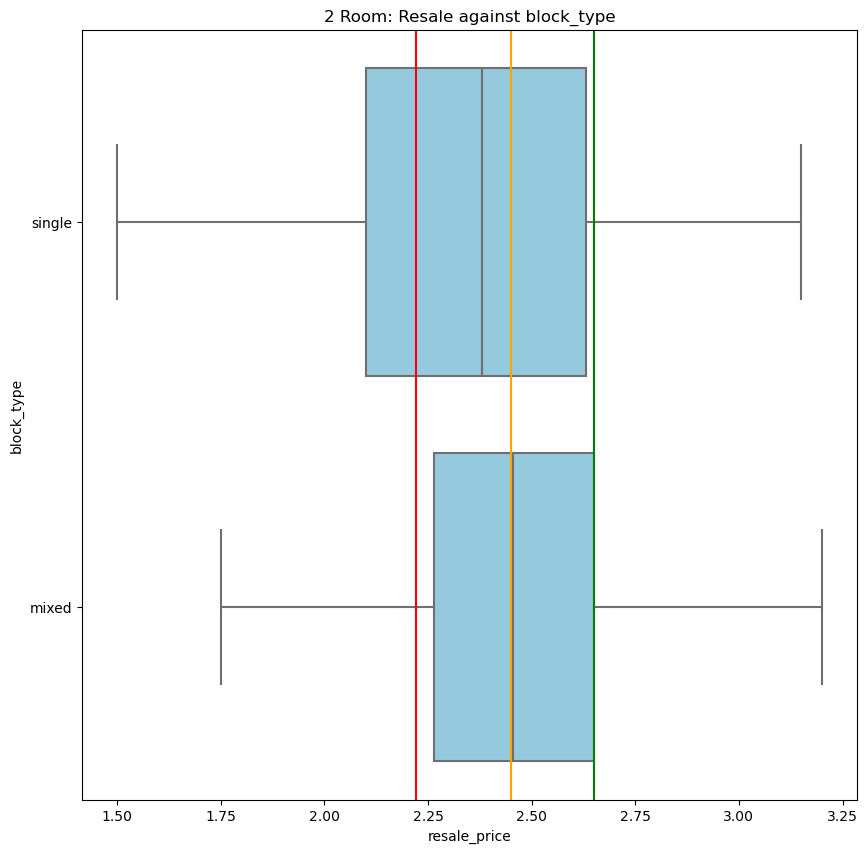

In [21]:
boxes(df_2room, list_of_categorical_features, '2 Room')

From the boxes, we can see that DBSS is an outlier so we will include the feature `2rm_dbss`.

We'll use the upper quantile, median, and lower quantile to split the planning areas into very expensive, expensive, affordable, cheap.

There seems to be minimal effect on block type so we'll just leave it.

In [22]:
area_median_price_data = df_2room.groupby(by='planning_area').agg({'resale_price':np.median})

def area_sorter_2rm(row):
    price = row['resale_price']
    lower = df_2room['resale_price'].quantile(.25)
    median = df_2room['resale_price'].quantile(.5)
    upper = df_2room['resale_price'].quantile(.75)
    if price<lower:
        row['area_cost']='cheap'
        return row
    if price<median:
        row['area_cost']='affordable'
        return row
    if price<upper:
        row['area_cost']='expensive'
        return row
    row['area_cost']='very expensive'
    return row

new = area_median_price_data.apply(area_sorter_2rm, axis = 1)
new_dict = new['area_cost'].to_dict()

df_2room['area_cost']=df_2room['planning_area'].map(new_dict)

In [23]:
df_2room[['planning_area','area_cost']].head()

,planning_area,area_cost
67,Toa Payoh,affordable
98,Geylang,affordable
175,Bedok,affordable
349,Bukit Merah,expensive
410,Jurong East,affordable


---

# 3 room flats

In [24]:
df_3room = df[df['flat_type']==flat_types[2]].copy()

In [25]:
find_sig_corr(df_3room,list_of_numeric_features)

resale_price:0.9999999999999999
price_per_sqft:0.8770388837341277


There appears to be no strong correlation between resale prices of 3 room flats and the numerical features.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

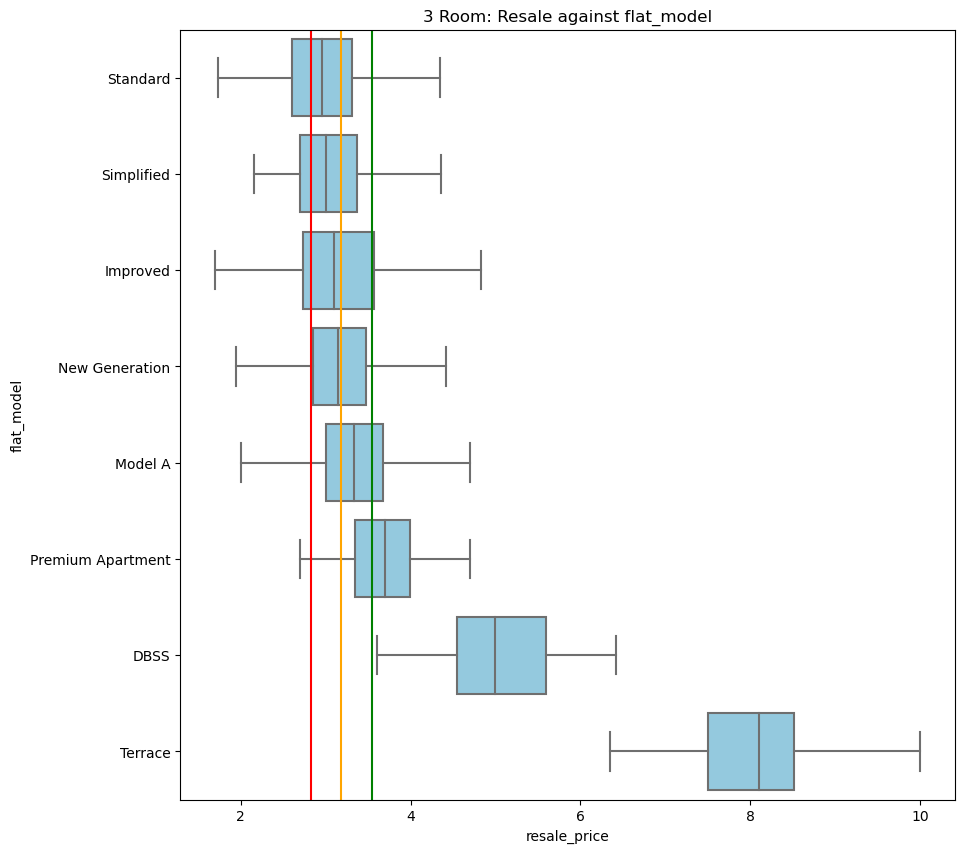

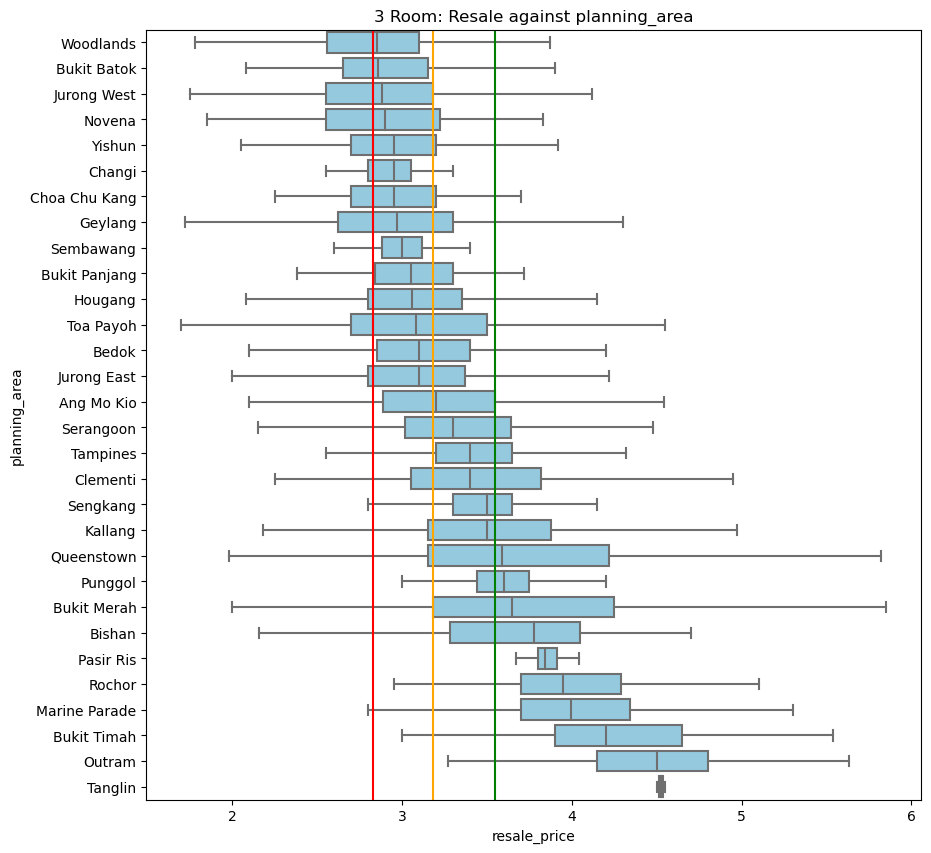

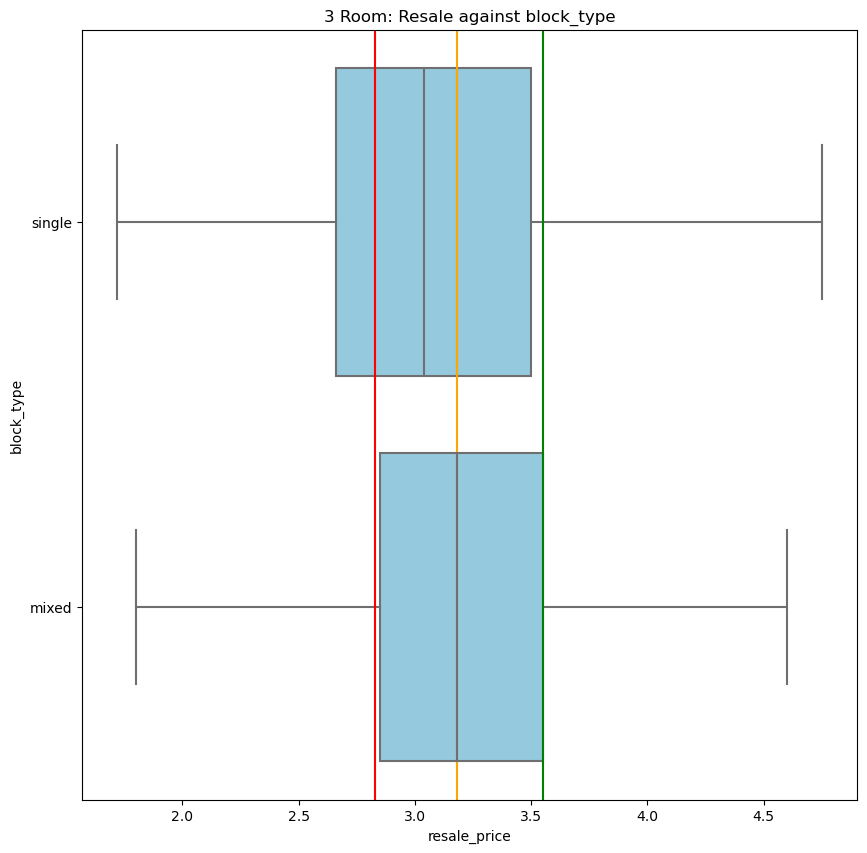

In [26]:
boxes(df_3room, list_of_categorical_features, '3 Room')

From the boxes, we can see that Premium Apartment, DBSS, and Terrace are outliers so we will include the feature `3rm_dbss`, `3rm_pa`, `3rm_ter`.

We'll use the upper quantile, median, and lower quantile to split the planning areas into very expensive, expensive, affordable, cheap.

There seems to be minimal effect on block type so we'll just leave it.

In [27]:
area_median_price_data = df_3room.groupby(by='planning_area').agg({'resale_price':np.median})

def area_sorter_3rm(row):
    price = row['resale_price']
    lower = df_3room['resale_price'].quantile(.25)
    median = df_3room['resale_price'].quantile(.5)
    upper = df_3room['resale_price'].quantile(.75)
    if price<lower:
        row['area_cost']='cheap'
        return row
    if price<median:
        row['area_cost']='affordable'
        return row
    if price<upper:
        row['area_cost']='expensive'
        return row
    row['area_cost']='very expensive'
    return row

new = area_median_price_data.apply(area_sorter_3rm, axis = 1)
new_dict = new['area_cost'].to_dict()

df_3room['area_cost']=df_3room['planning_area'].map(new_dict)

In [28]:
df_3room[['planning_area','area_cost']].head()

,planning_area,area_cost
5,Geylang,affordable
7,Bedok,affordable
11,Tampines,expensive
15,Bukit Panjang,affordable
28,Toa Payoh,affordable


---

# 4 room flats

In [29]:
df_4room = df[df['flat_type']==flat_types[3]].copy()

In [30]:
find_sig_corr(df_4room,list_of_numeric_features)

resale_price:1.0
price_per_sqft:0.9525884394820245
max_floor_lvl:0.6414583905262956
Latitude:-0.5581733653971289
Hawker_Within_1km:0.5177600366296999
Hawker_Within_2km:0.5987920788390992
mrt_latitude:-0.5505293329306011
bus_stop_latitude:-0.5575483229705005
pri_sch_latitude:-0.5601460458347342
sec_sch_latitude:-0.557324522206325


For 4 room flat buyers, it seems like how high the HDB block matters.

They also like having many hawkerstalls within a 2km radius. (Since it has a stronger correlation, we'll use 2km instead of 1km)

It will also appear that flats in the south are more expensive. (From all the latitudes)

Let's look at the max storey against resale price. We'll also color it by planning area because we'll want to see if there is a correlation between how high the max storey and the planning area. (For example, Paya Labar could not have higher HDB because of a nearby airbase)

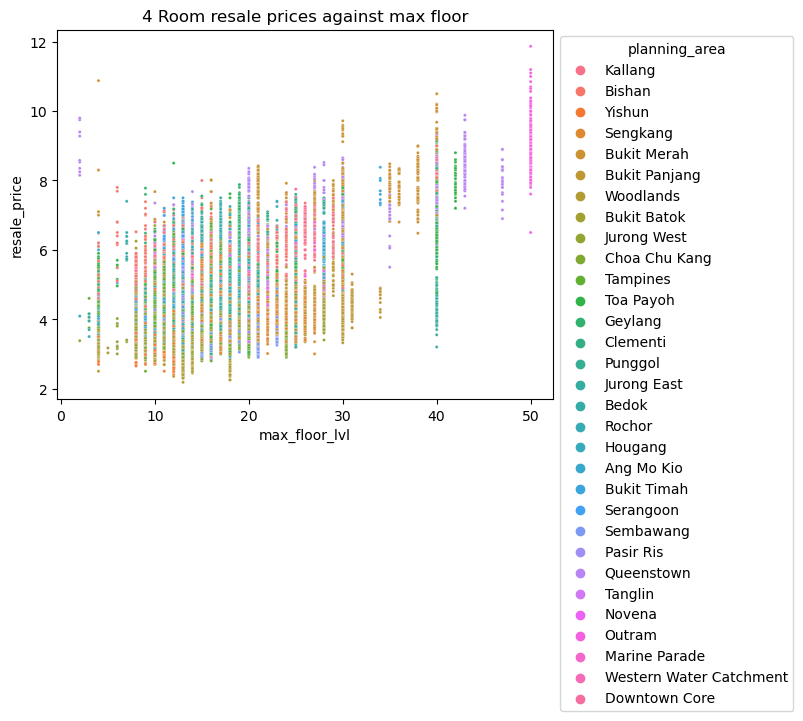

In [31]:
plt.title('4 Room resale prices against max floor')
ax = sns.scatterplot(data=df_4room, x='max_floor_lvl', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

It is clear that after 40 storeys, the price can also be attributed to planning area.

As for the rest of the max number of storeys, there is more or less the same variation.

We thus will not add this feature into the model.

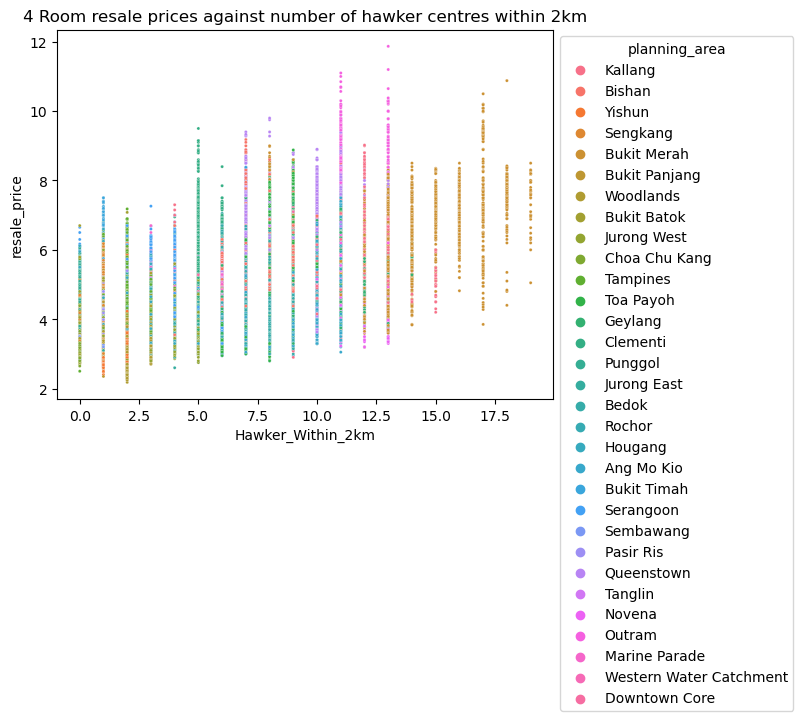

In [32]:
plt.title('4 Room resale prices against number of hawker centres within 2km')
ax = sns.scatterplot(data=df_4room, x='Hawker_Within_2km', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

On average, it looks like we can attribute higher resale prices of 4-room flats to the number of hawker centres within 2km.

We will include `flat_type_4 ROOM`\*`Hawker_Within_2km` in the model.

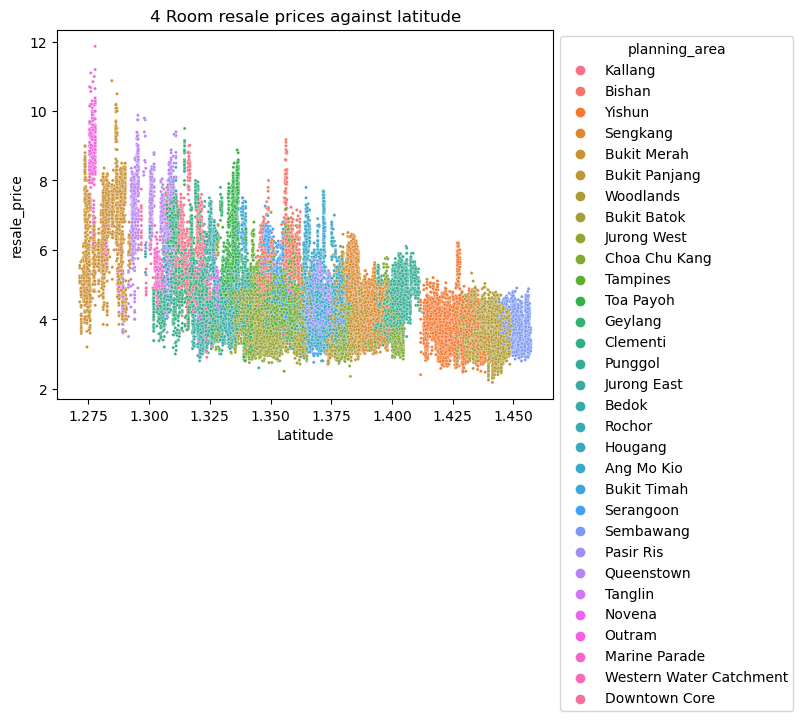

In [33]:
plt.title('4 Room resale prices against latitude')
ax = sns.scatterplot(data=df_4room, x='Latitude', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

We can see distinct bands of color, meaning that the planning area is a stronger explainer than latitude.

We will not add `Latitude` to our model.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

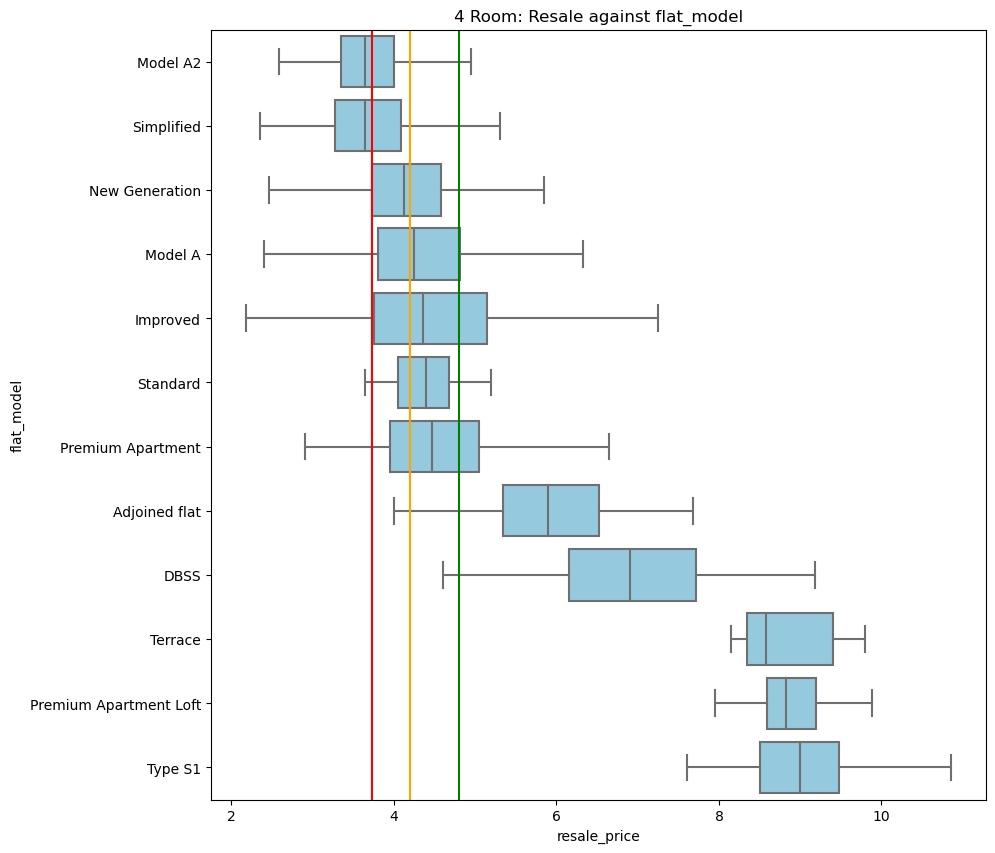

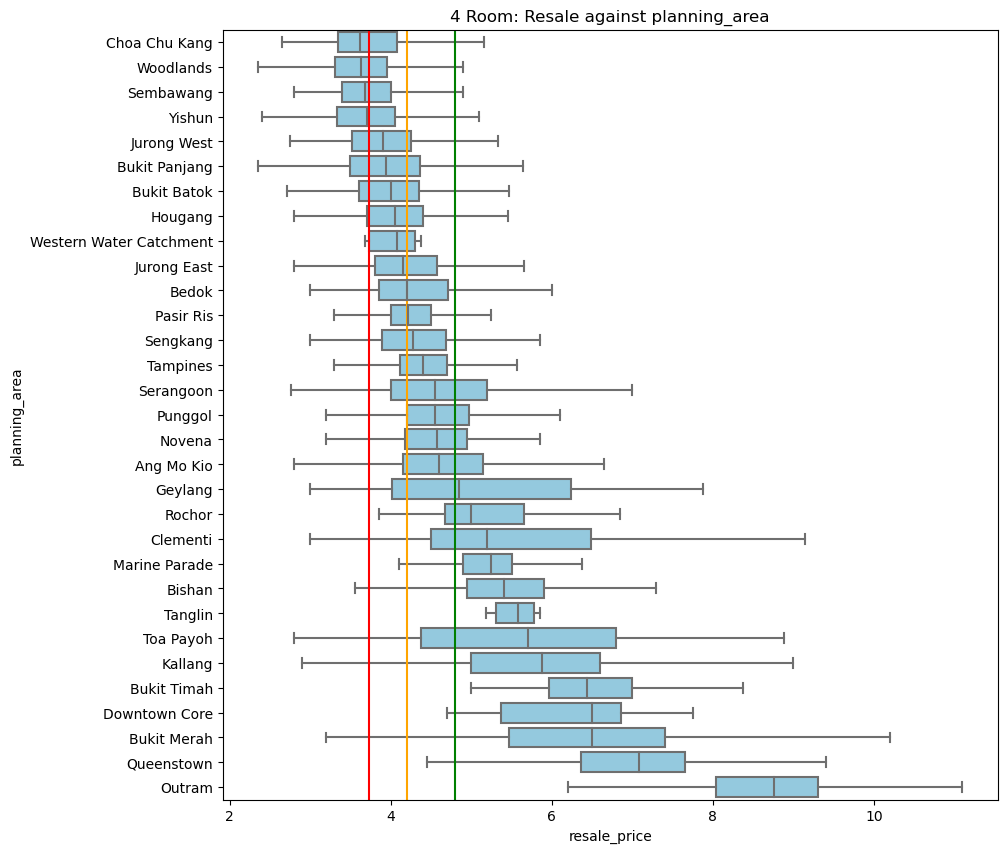

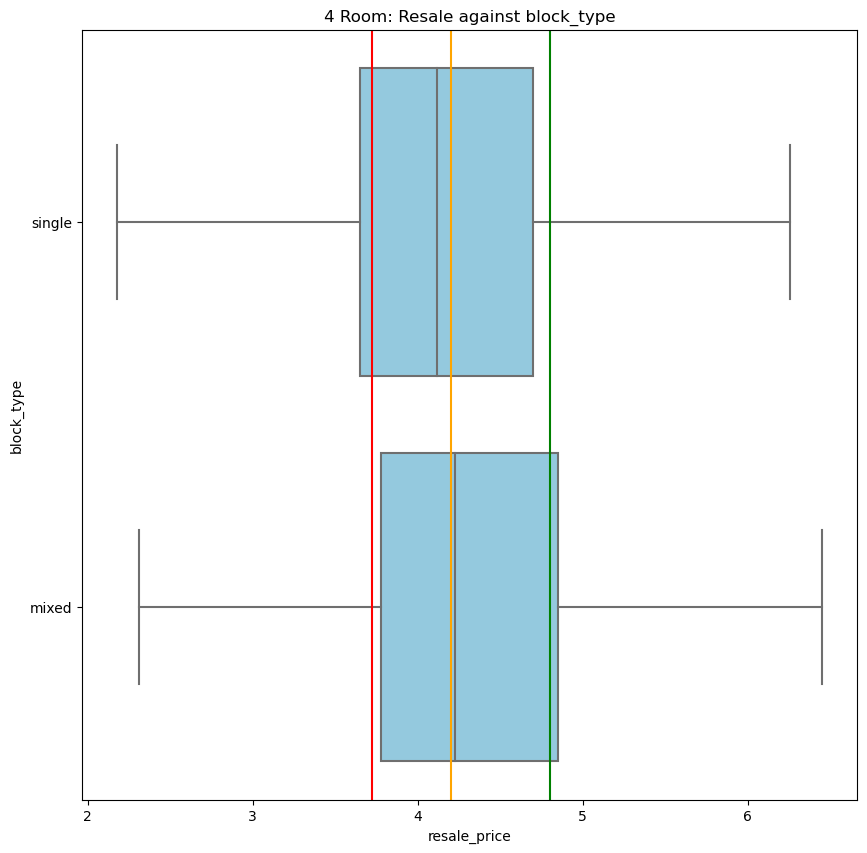

In [34]:
boxes(df_4room, list_of_categorical_features, '4 Room')

From the boxes, we can see that Model A2 and Simplified are distinctly cheaper, and Adjoint flat, DBSS, Terrace, Premium Apartment Loft, Type S1 are indicative of higher prices. We will add in those features.

We'll use the upper quantile, median, and lower quantile to split the planning areas into very expensive, expensive, affordable, cheap.

There seems to be minimal effect on block type so we'll just leave it.

In [35]:
area_median_price_data = df_4room.groupby(by='planning_area').agg({'resale_price':np.median})

def area_sorter_4rm(row):
    price = row['resale_price']
    lower = df_4room['resale_price'].quantile(.25)
    median = df_4room['resale_price'].quantile(.5)
    upper = df_4room['resale_price'].quantile(.75)
    if price<lower:
        row['area_cost']='cheap'
        return row
    if price<median:
        row['area_cost']='affordable'
        return row
    if price<upper:
        row['area_cost']='expensive'
        return row
    row['area_cost']='very expensive'
    return row

new = area_median_price_data.apply(area_sorter_4rm, axis = 1)
new_dict = new['area_cost'].to_dict()

df_4room['area_cost']=df_4room['planning_area'].map(new_dict)

In [36]:
df_4room[['planning_area','area_cost']].head()

,planning_area,area_cost
0,Kallang,very expensive
3,Bishan,very expensive
4,Yishun,cheap
10,Sengkang,expensive
13,Bukit Merah,very expensive


---

# 5 room flats

In [37]:
df_5room = df[df['flat_type']==flat_types[4]].copy()

In [38]:
find_sig_corr(df_5room,list_of_numeric_features)

resale_price:1.0
price_per_sqft:0.9680653574153216
max_floor_lvl:0.6061397212370334
Latitude:-0.6067416639693926
Hawker_Within_1km:0.612991749220691
Hawker_Within_2km:0.695497076438273
mrt_latitude:-0.5935465958416624
bus_stop_latitude:-0.6066052264967497
pri_sch_latitude:-0.6052755087497743
sec_sch_latitude:-0.6032429745227711


Again, max floor and hawker centres stand out.

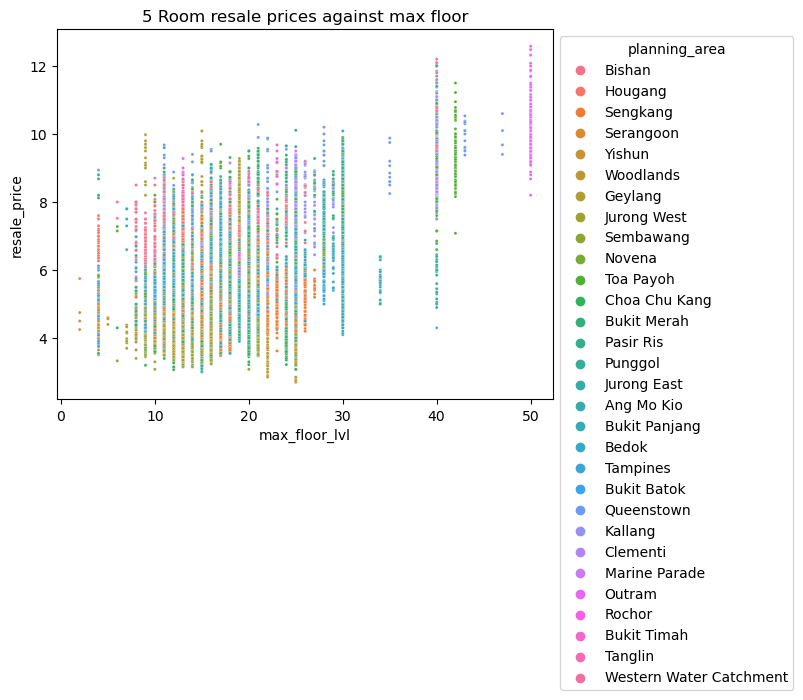

In [39]:
plt.title('5 Room resale prices against max floor')
ax = sns.scatterplot(data=df_5room, x='max_floor_lvl', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

Similar to the analysis for 4 room, we will not add in this feature.

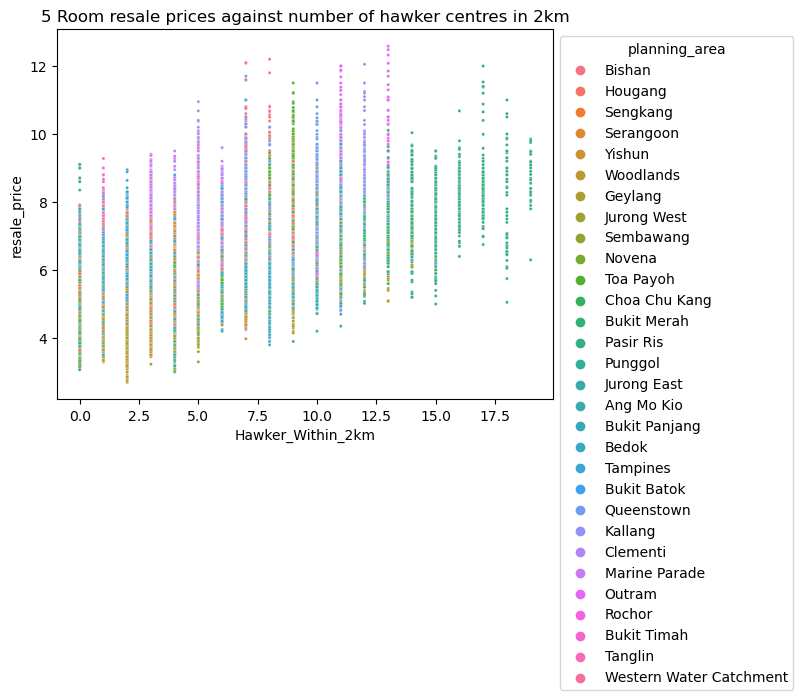

In [40]:
plt.title('5 Room resale prices against number of hawker centres in 2km')
ax = sns.scatterplot(data=df_5room, x='Hawker_Within_2km', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

Similar to the analysis for 4 room, we will include `flat_type_5 ROOM`\*`Hawker_Within_2km`.

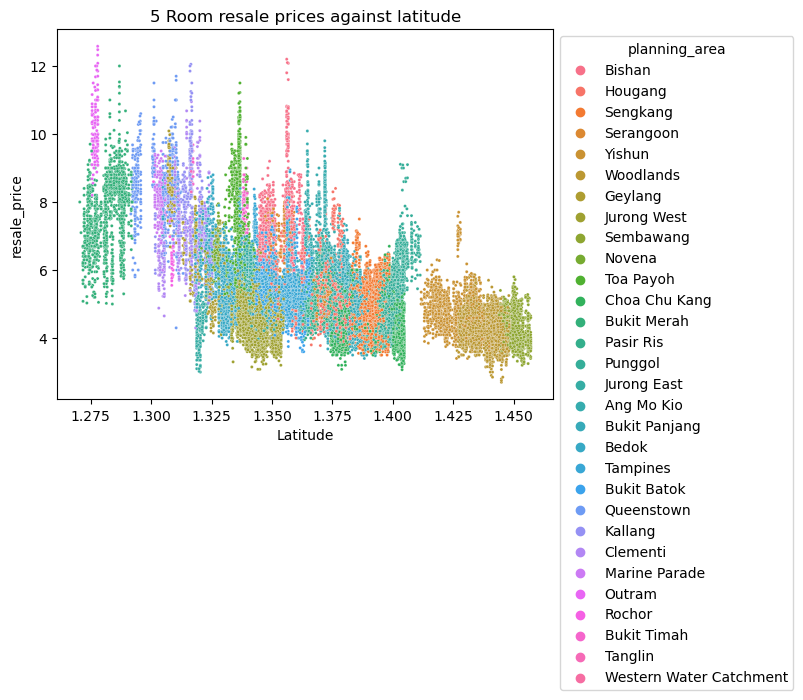

In [41]:
plt.title('5 Room resale prices against latitude')
ax = sns.scatterplot(data=df_5room, x='Latitude', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

The correlation here is not clearly linear. We can see that in the middle, there are units whose prices are higher.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

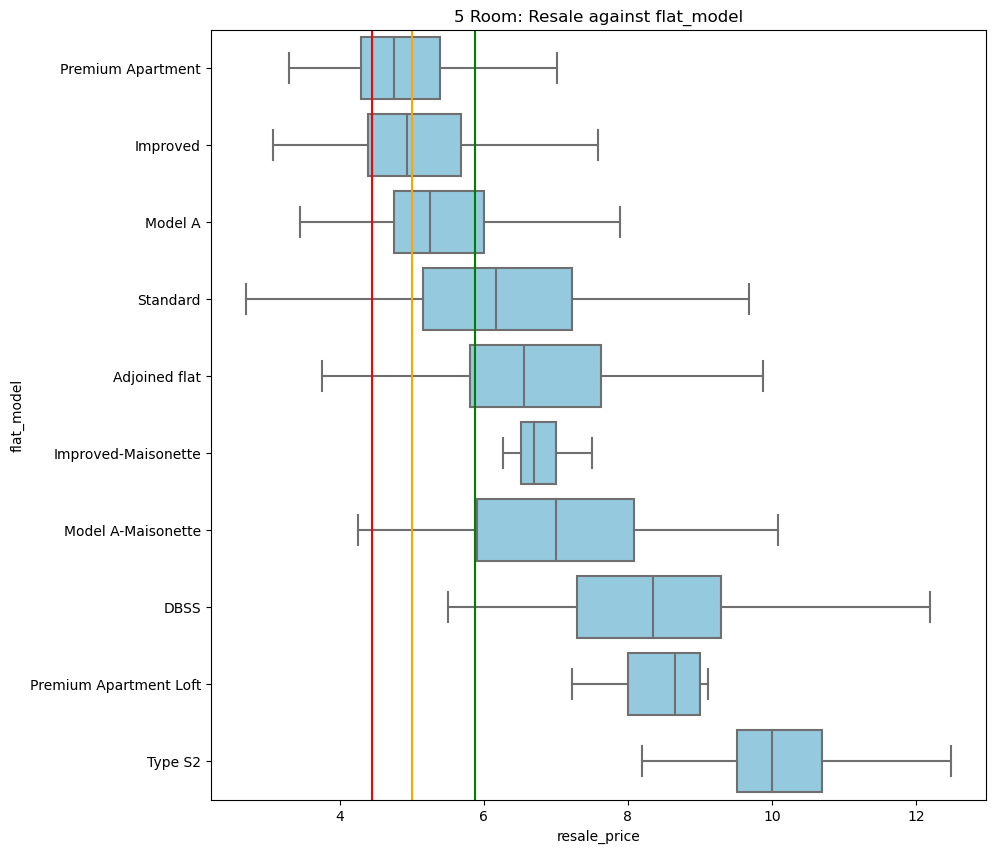

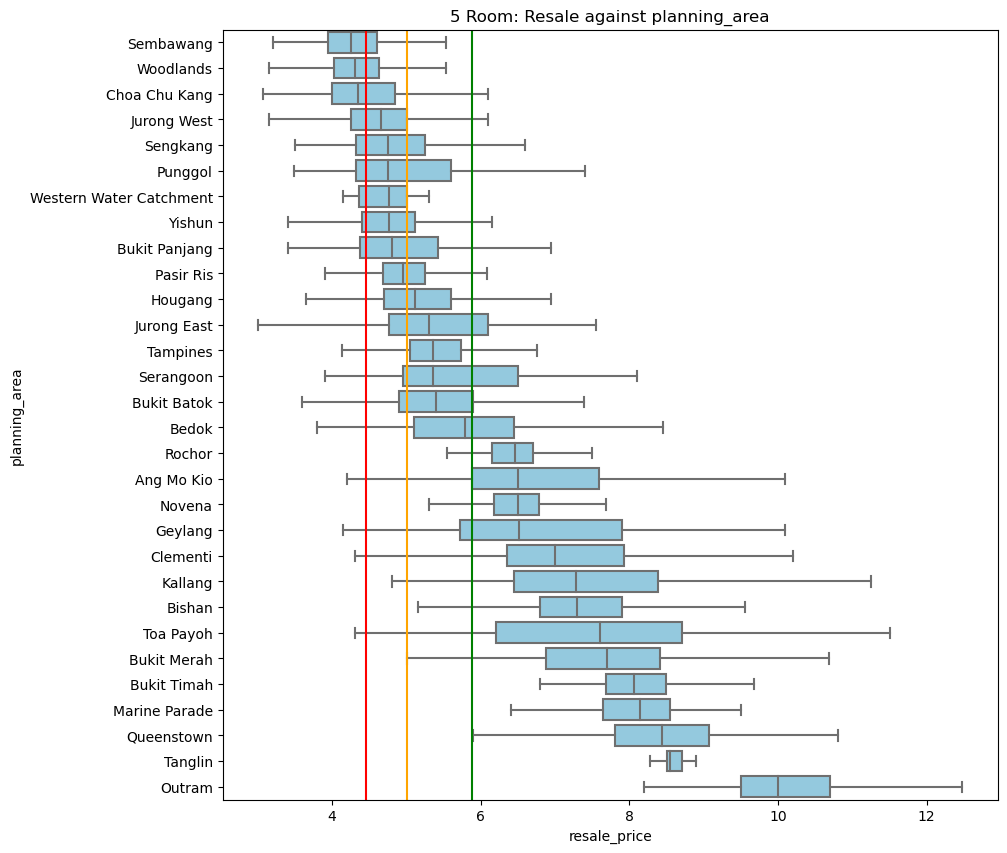

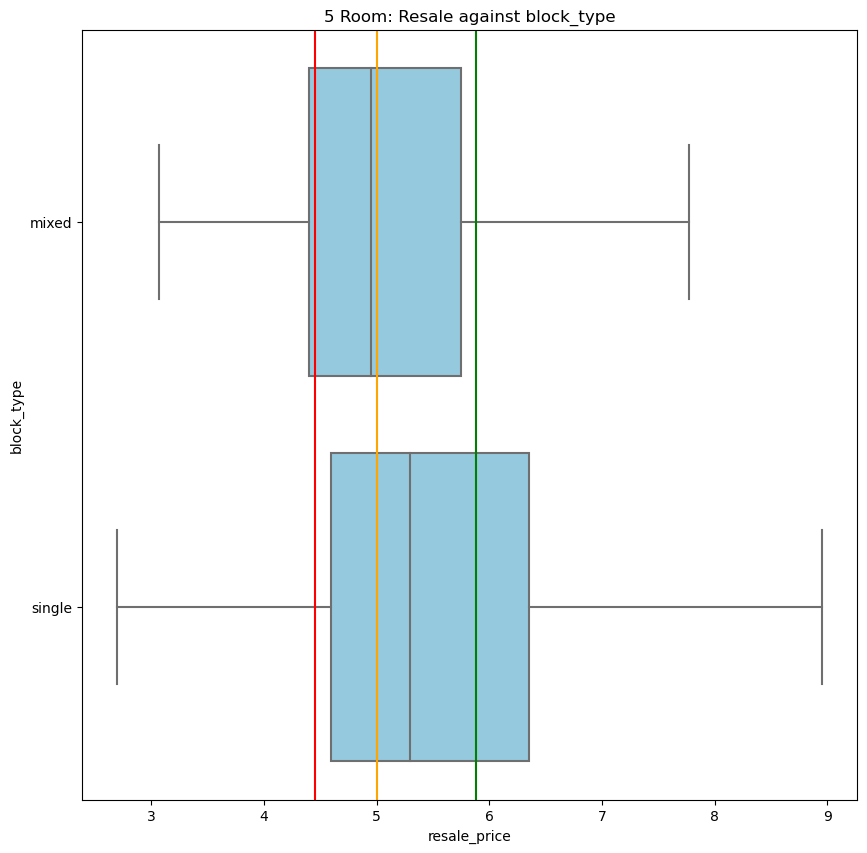

In [42]:
boxes(df_5room, list_of_categorical_features, '5 Room')

From the boxes, we can see that Type S2, Premium Apartment Loft, DBSS, Improved-Maisonette, Standard ,and Adjoined flat are generally more expensive than Model A, improved and premium apartment. We'll use the more expensive ones for additional features.

We'll use the upper quantile, median, and lower quantile to split the planning areas into very expensive, expensive, affordable, cheap.

There seems to be minimal effect on block type so we'll just leave it.

In [43]:
area_median_price_data = df_5room.groupby(by='planning_area').agg({'resale_price':np.median})

def area_sorter_5rm(row):
    price = row['resale_price']
    lower = df_5room['resale_price'].quantile(.25)
    median = df_5room['resale_price'].quantile(.5)
    upper = df_5room['resale_price'].quantile(.75)
    if price<lower:
        row['area_cost']='cheap'
        return row
    if price<median:
        row['area_cost']='affordable'
        return row
    if price<upper:
        row['area_cost']='expensive'
        return row
    row['area_cost']='very expensive'
    return row

new = area_median_price_data.apply(area_sorter_5rm, axis = 1)
new_dict = new['area_cost'].to_dict()

df_5room['area_cost']=df_5room['planning_area'].map(new_dict)

In [44]:
df_5room[['planning_area','area_cost']].head()

,planning_area,area_cost
1,Bishan,very expensive
6,Hougang,expensive
8,Bishan,very expensive
9,Sengkang,affordable
12,Serangoon,expensive


---

# Executive flats

In [45]:
df_exec = df[df['flat_type']==flat_types[5]].copy()

In [46]:
find_sig_corr(df_exec,list_of_numeric_features)

resale_price:1.0
price_per_sqft:0.9070321423450443
Hawker_Within_2km:0.5740006353881577


Hawker centres stand out.

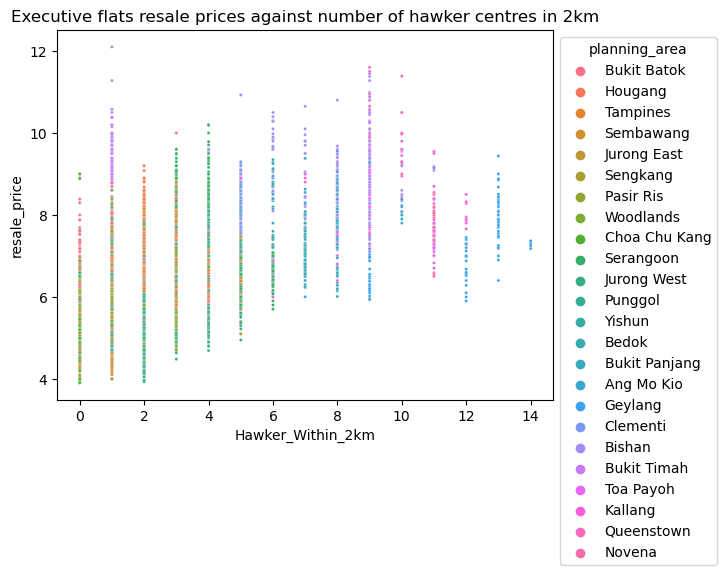

In [47]:
plt.title('Executive flats resale prices against number of hawker centres in 2km')
ax = sns.scatterplot(data=df_exec, x='Hawker_Within_2km', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

We can see that there is a general trend upwards, so we'll include this in our model.

Similar to the analysis for 4,5 room, we will include `flat_type_EXECUTIVE`\*`Hawker_Within_2km`.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

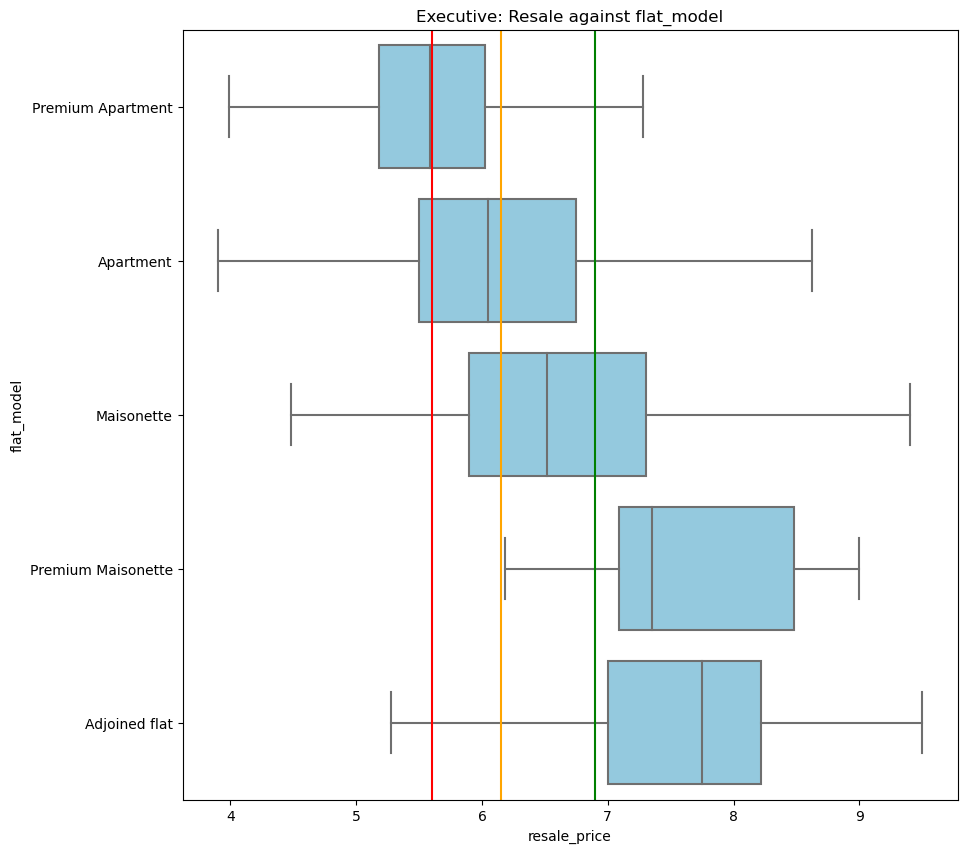

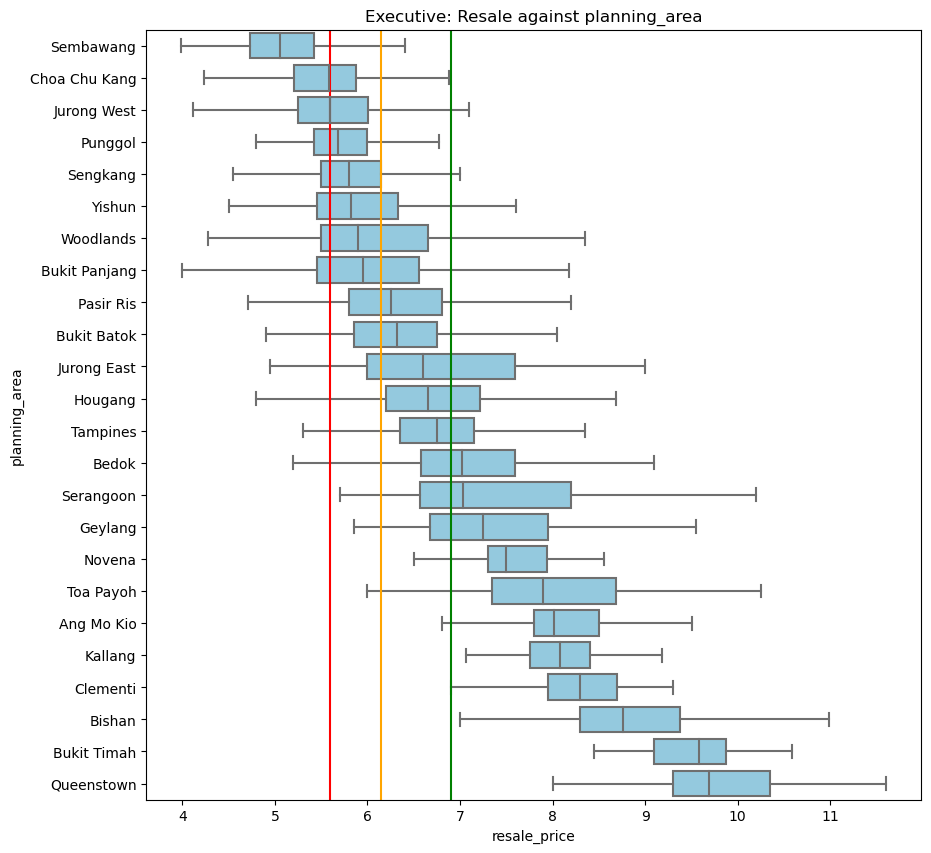

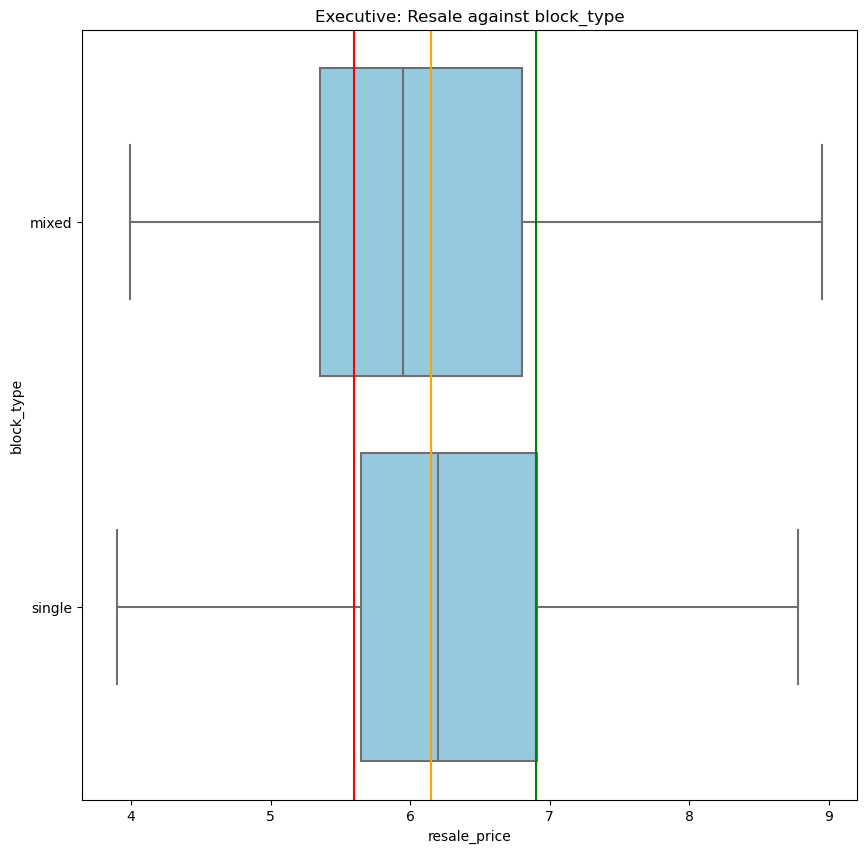

In [48]:
boxes(df_exec, list_of_categorical_features, 'Executive')

From the boxes, we can see that Premium Maisonette and Adjoined flat standout.

We'll use the upper quantile, median, and lower quantile to split the planning areas into very expensive, expensive, affordable, cheap.

There seems to be minimal effect on block type so we'll just leave it.

In [49]:
area_median_price_data = df_exec.groupby(by='planning_area').agg({'resale_price':np.median})

def area_sorter_5rm(row):
    price = row['resale_price']
    lower = df_exec['resale_price'].quantile(.25)
    median = df_exec['resale_price'].quantile(.5)
    upper = df_exec['resale_price'].quantile(.75)
    if price<lower:
        row['area_cost']='cheap'
        return row
    if price<median:
        row['area_cost']='affordable'
        return row
    if price<upper:
        row['area_cost']='expensive'
        return row
    row['area_cost']='very expensive'
    return row

new = area_median_price_data.apply(area_sorter_5rm, axis = 1)
new_dict = new['area_cost'].to_dict()

df_exec['area_cost']=df_exec['planning_area'].map(new_dict)

In [50]:
df_exec[['planning_area','area_cost']].head()

,planning_area,area_cost
2,Bukit Batok,expensive
23,Hougang,expensive
49,Tampines,expensive
57,Sembawang,cheap
70,Jurong East,expensive


---

# Multi-generation flats

In [51]:
df_mulgen = df[df['flat_type']==flat_types[6]].copy()

In [52]:
find_sig_corr(df_mulgen,list_of_numeric_features)

resale_price:0.9999999999999999
price_per_sqft:0.7234790225289155
Latitude:-0.500707363618328
Hawker_Within_2km:0.5994839940024552
hawker_food_stalls:0.5223148938108654
hawker_market_stalls:0.548597411762797
mrt_latitude:-0.502354373609828
bus_stop_latitude:-0.5010890629339609
sec_sch_latitude:-0.5082585916935278


We see a trend here with the hawker centres.

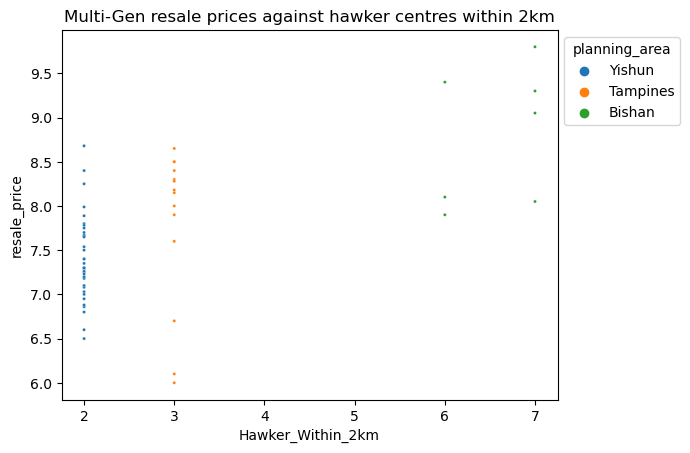

In [53]:
plt.title('Multi-Gen resale prices against hawker centres within 2km')
ax = sns.scatterplot(data=df_mulgen, x='Hawker_Within_2km', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

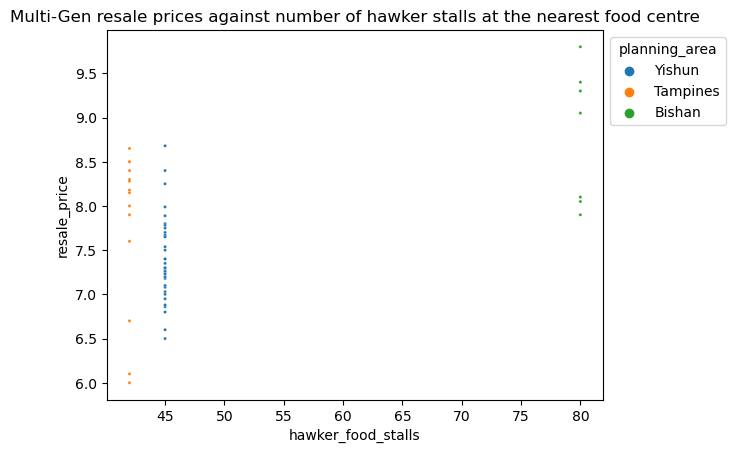

In [54]:
plt.title('Multi-Gen resale prices against number of hawker stalls at the nearest food centre')
ax = sns.scatterplot(data=df_mulgen, x='hawker_food_stalls', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

Again, planning area.

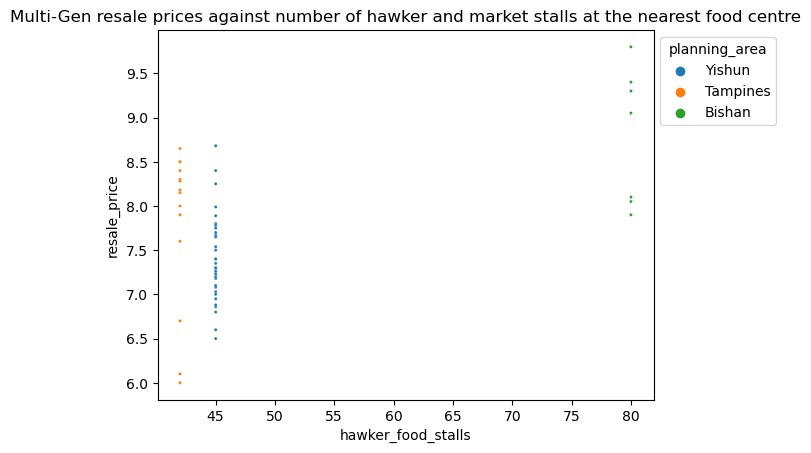

In [55]:
plt.title('Multi-Gen resale prices against number of hawker and market stalls at the nearest food centre')
ax = sns.scatterplot(data=df_mulgen, x='hawker_food_stalls', y='resale_price', hue='planning_area', s=5)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1));

We can clearly see that planning area explains the high prices more than the number of hawker stalls.

We will not add the feature in.

We will do boxplot plots to see if we can find any correlations between resale price and other categorical features.

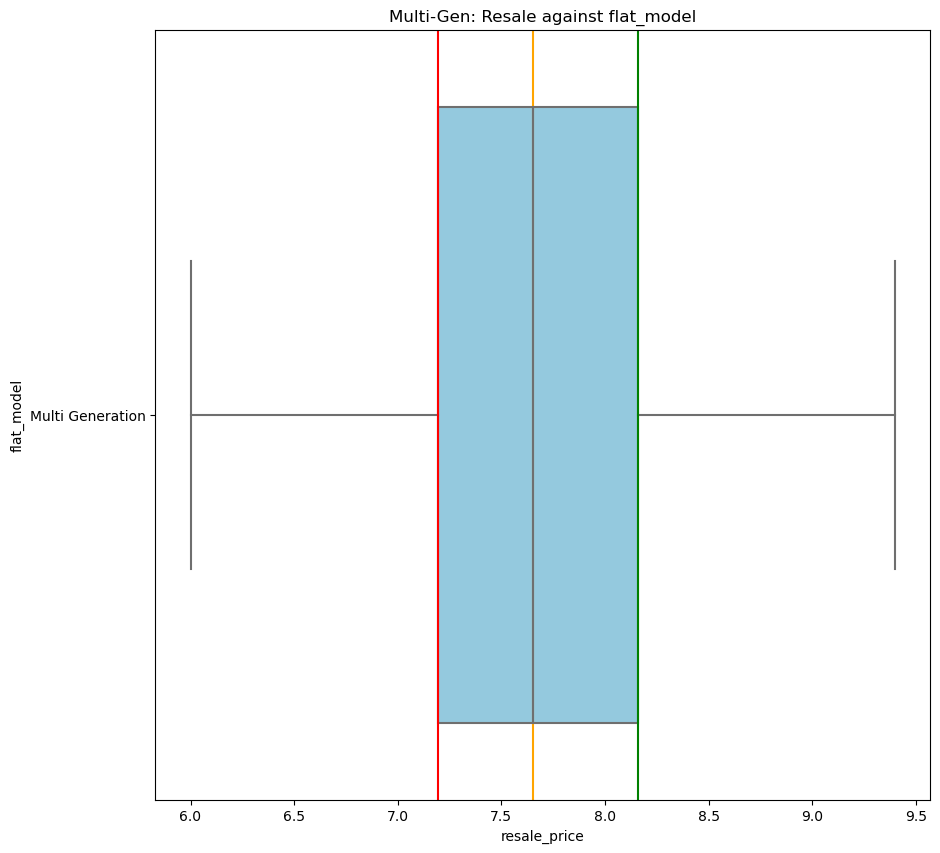

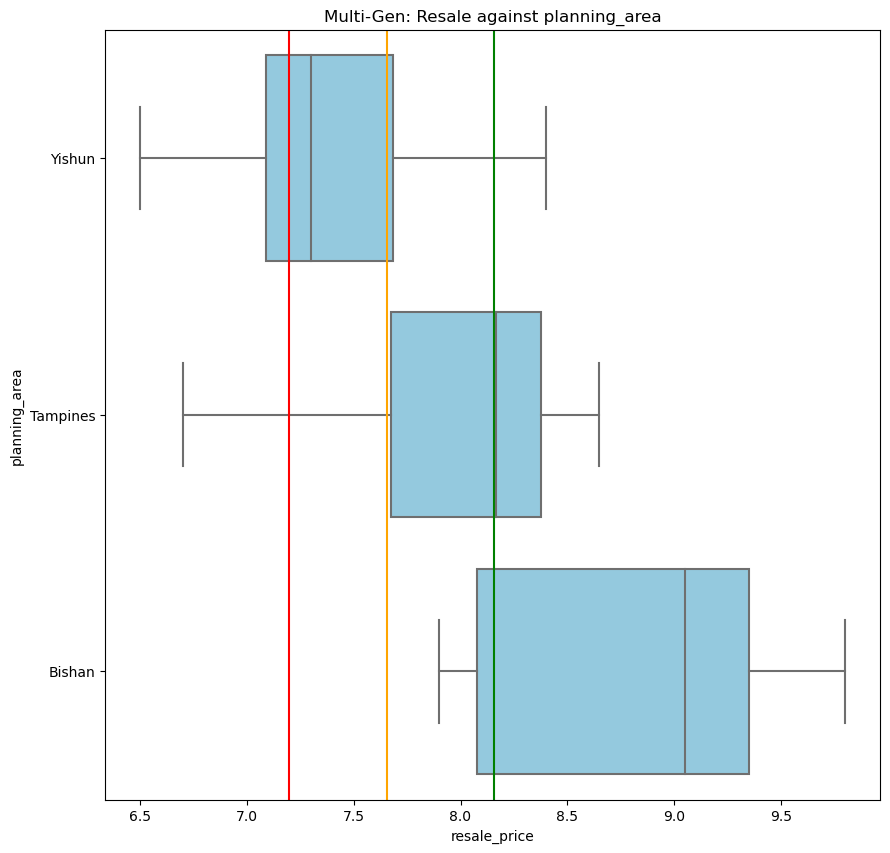

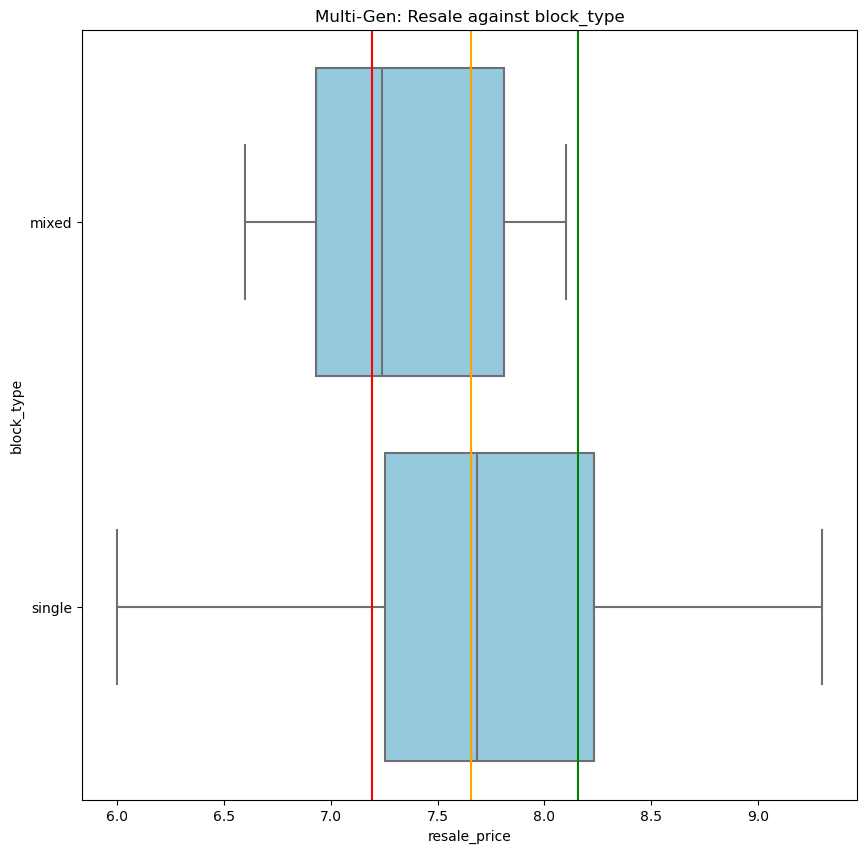

In [56]:
boxes(df_mulgen, list_of_categorical_features, 'Multi-Gen')

We'll use the upper quantile, median, and lower quantile to split the planning areas into very expensive, expensive, affordable, cheap.

There seems to be minimal effect on block type so we'll just leave it.

In [57]:
area_median_price_data = df_mulgen.groupby(by='planning_area').agg({'resale_price':np.median})

def area_sorter_mulgen(row):
    price = row['resale_price']
    lower = df_mulgen['resale_price'].quantile(.25)
    median = df_mulgen['resale_price'].quantile(.5)
    upper = df_mulgen['resale_price'].quantile(.75)
    if price<lower:
        row['area_cost']='cheap'
        return row
    if price<median:
        row['area_cost']='affordable'
        return row
    if price<upper:
        row['area_cost']='expensive'
        return row
    row['area_cost']='very expensive'
    return row

new = area_median_price_data.apply(area_sorter_mulgen, axis = 1)
new_dict = new['area_cost'].to_dict()

df_mulgen['area_cost']=df_mulgen['planning_area'].map(new_dict)

In [58]:
df_mulgen[['planning_area','area_cost']].head()

,planning_area,area_cost
2023,Yishun,affordable
2927,Yishun,affordable
5592,Yishun,affordable
9849,Tampines,very expensive
15015,Yishun,affordable


In [59]:
df['area_cost']=pd.concat([df_2room['area_cost'],df_3room['area_cost'],df_4room['area_cost'],df_5room['area_cost'],df_exec['area_cost'],df_mulgen['area_cost']])

In [60]:
df['area_cost'].isnull().sum()

82

Our 1 ROOM flats only has Bukit Merah and generally it is considered an expensive area cost.

Thus we will fill the null values with Bukit Merah.

In [65]:
df['area_cost'] = df['area_cost'].fillna('expensive')

In [66]:
df.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,affiliation,sec_sch_latitude,sec_sch_longitude,block_type,Tranc_YearMonth_ord,Tranc_Year_ord,Tranc_Month_ord,lease_commence_date_ord,year_completed_ord,area_cost
0,88471,2016-05-01,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006-01-01,...,0,1.317659,103.882504,mixed,736085,735964,693716,732312,731947,very expensive
1,122598,2012-07-01,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987-01-01,...,0,1.350110,103.854892,mixed,734685,734503,693777,725372,725372,very expensive
2,170897,2013-07-01,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997-01-01,...,0,1.342334,103.760013,mixed,735050,734869,693777,729025,728659,expensive
3,86070,2012-04-01,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992-01-01,...,1,1.354789,103.844934,mixed,734594,734503,693686,727198,726468,very expensive
4,153632,2017-12-01,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987-01-01,...,0,1.414888,103.838335,mixed,736664,736330,693930,725372,725372,cheap


In [67]:
df.to_csv('..\datasets\cleaned_df_2.csv')